In [11]:
#import packages
import numpy as np
import pandas as pd

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('./Dataset/BanksDataset/ICICIBANK.csv')

#print the head
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,ICICIBANK,EQ,69.20,74.35,74.75,71.40,74.75,74.75,73.20,286260,2.095439e+12,NaN,NaN,NaN
1,2000-01-04,ICICIBANK,EQ,74.75,73.05,78.50,71.00,73.25,73.05,73.38,296264,2.173893e+12,NaN,NaN,NaN
2,2000-01-05,ICICIBANK,EQ,73.05,70.00,73.50,67.50,70.00,69.50,70.85,227624,1.612794e+12,NaN,NaN,NaN
3,2000-01-06,ICICIBANK,EQ,69.50,71.00,74.00,69.55,69.75,70.05,72.04,275149,1.982121e+12,NaN,NaN,NaN
4,2000-01-07,ICICIBANK,EQ,70.05,69.00,72.50,66.00,67.00,67.40,68.72,138809,9.538882e+11,NaN,NaN,NaN


In [12]:
df1 = df.reset_index()['Close']

In [13]:
df1.shape

(5097,)

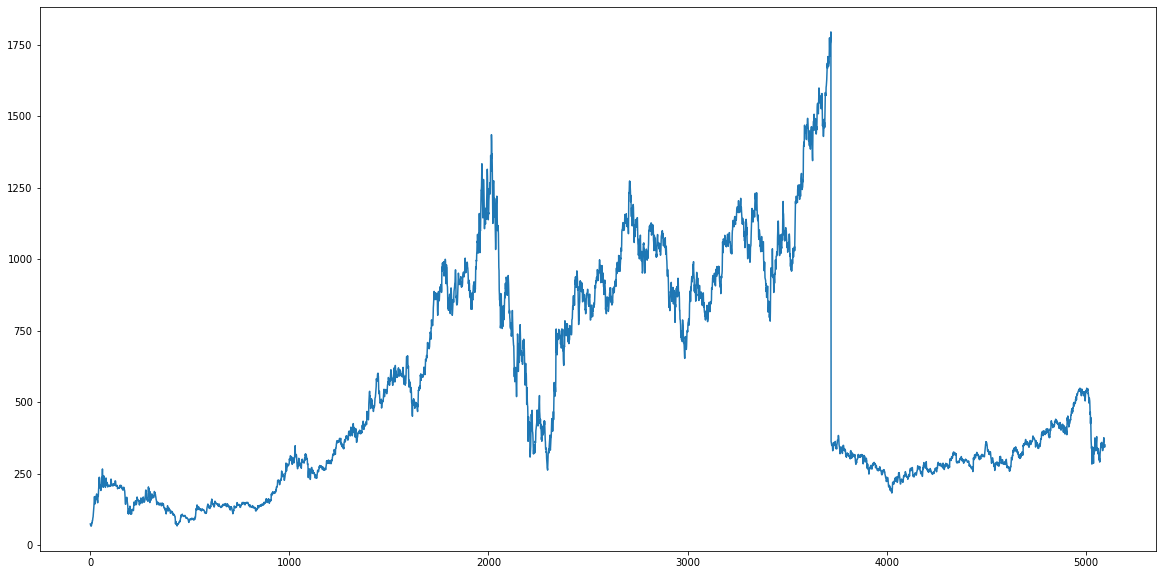

In [14]:
# Plotting the dataframe
plt.plot(df1)

In [15]:
df1= scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [18]:
# SPLITTING INTO TRAIN AND TEST
#deciding the split size
trainSize = int(len(df1)*0.65)
testSize= len(df1)- trainSize

#Making the splits
trainData, testData = df1[0:trainSize, :],df1[trainSize:len(df1), :1 ] 

In [19]:
len(trainData), len(testData)


(3313, 1784)

In [20]:
# Converting the array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY= [],[]
    for i in range(len(dataset)-time_step-1):
        a= dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [21]:
time_step= 320
X_train, Y_train= create_dataset(trainData, time_step)
X_test, Y_test= create_dataset(testData, time_step)

In [22]:
print(X_train.shape)

(2992, 320)


In [23]:
print(Y_train.shape)

(2992,)


In [24]:
#Before going into LSTM, we have to make our data 3D
X_train= X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test= X_test.reshape(X_test.shape[0], X_test.shape[1],1)


In [25]:
#Creating the stacked LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [26]:

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(320,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [28]:
model.fit(X_train, Y_train, validation_data= (X_test, Y_test), epochs= 15, batch_size=128, verbose=1)

Train on 2992 samples, validate on 1463 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/15
2992/2992 [==============================] - 45s 15ms/sample - loss: 0.0297 - val_loss: 0.0077
Epoch 2/15
2992/2992 [==============================] - 41s 14ms/sample - loss: 0.0024 - val_loss: 0.0038
Epoch 3/15
2992/2992 [==============================] - 43s 14ms/sample - loss: 9.9159e-04 - val_loss: 0.0038
Epoch 4/15
2992/2992 [==============================] - 37s 12ms/sample - loss: 8.4726e-04 - val_loss: 0.0036
Epoch 5/15
2992/2992 [==============================] - 38s 13ms/sample - loss: 8.2830e-04 - val_loss: 0.0035
Epoch 6/15
2992/2992 [==============================] - 44s 15ms/sample - loss: 8.1493e-04 - val_loss: 0.0034
Epoch 7/15
2992/2992 [==============================] - 48s 16ms/sample - loss: 7.8557e-04 - val_loss: 0.0034
Epoch 8/15
2992/2992 [==============================] - 47s 16ms/sample - loss: 7.5098e-04 - val

In [29]:
import tensorflow as tf

#Doing the predictions
train_predict= model.predict(X_train)
test_predict= model.predict(X_test)

In [30]:
# transforming back to original , to perform RMSE
train_predict= scaler.inverse_transform(train_predict)
test_predict= scaler.inverse_transform(test_predict)

In [31]:
# Calculating RMSE Performance
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train, train_predict))


713.0094685111006

In [32]:
math.sqrt(mean_squared_error(Y_test, test_predict))

503.8601528594996

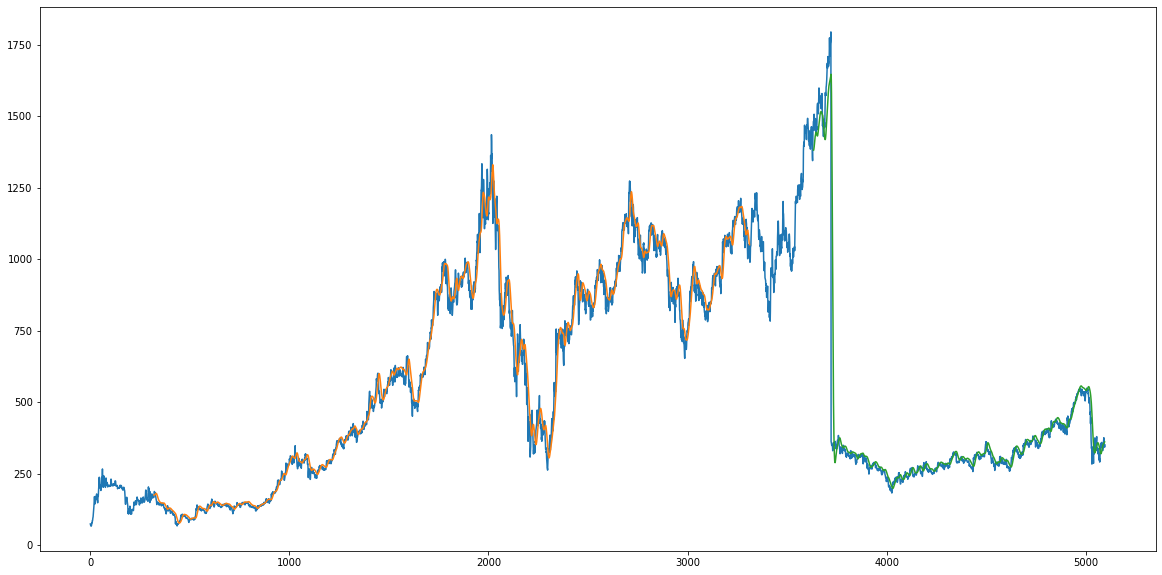

In [33]:
#Plotting the training and testing data
look_back= 320 #time stamp
#Training data
trainPredictPlot= np.empty_like(df1)
trainPredictPlot[:, :]= np.nan
trainPredictPlot[look_back: len(train_predict)+look_back, :]= train_predict

#Test Data
testPredictPlot= np.empty_like(df1)
testPredictPlot[:, :]= np.nan
testPredictPlot[len(train_predict)+(look_back*2) +1: len(df1) -1 , :]= test_predict

#Plotting the baseline and predictions

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [34]:
len(testData)

1784

In [35]:
x_input=testData[1464:].reshape(1,-1)
x_input.shape

(1, 320)

In [36]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [57]:
from numpy import array

lst_output=[]
n_steps=320
i=0
while(i<15):
    
    if(len(temp_input)>320):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)


[[0.3375314772129059], [0.33880868554115295], [0.340089350938797], [0.3413734436035156], [0.342661052942276], [0.3439520597457886], [0.34524643421173096], [0.34654420614242554], [0.3478451669216156], [0.3491494655609131], [0.3504570424556732], [0.35176780819892883], [0.35308173298835754], [0.35439881682395935], [0.3557189702987671]]
Invest


In [38]:
day_new=np.arange(1,321)
day_pred=np.arange(321,336)

In [39]:
len(df1)

5097

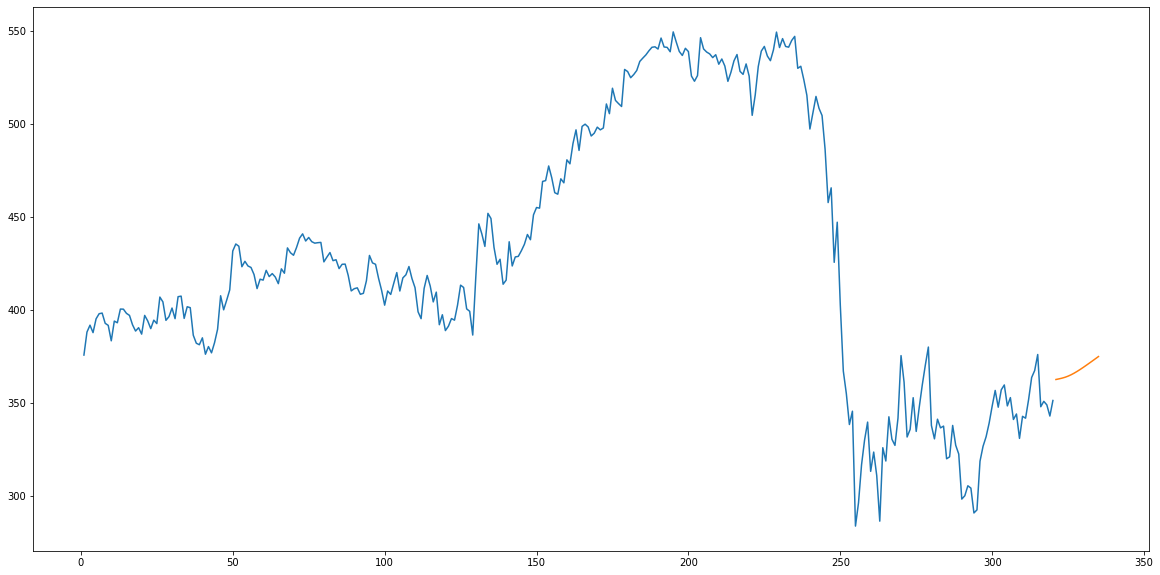

In [40]:

plt.plot(day_new,scaler.inverse_transform(df1[4777:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

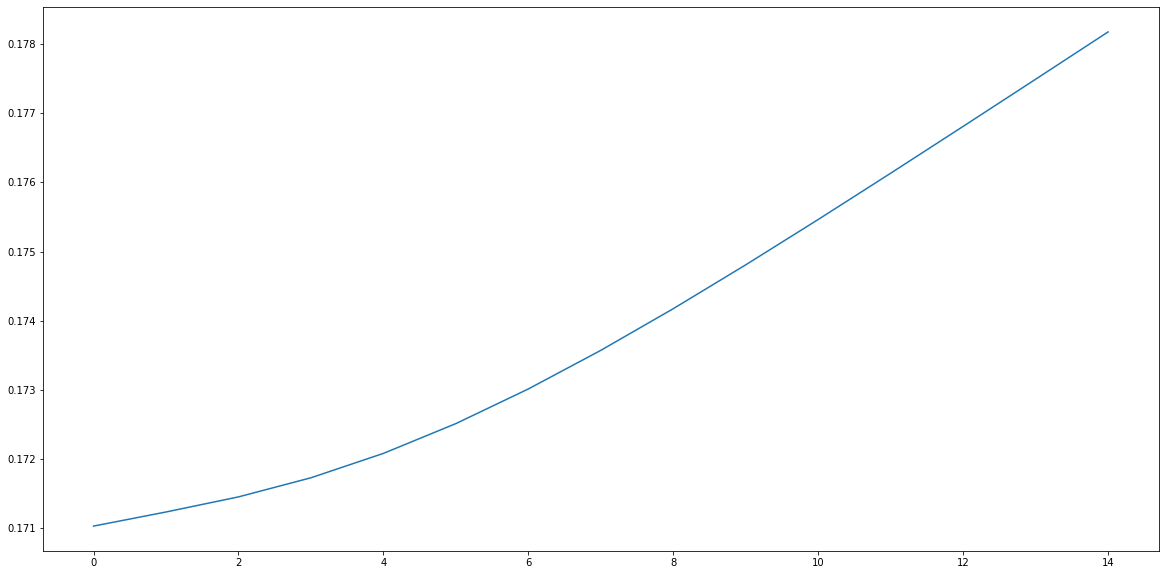

In [41]:
# Combining the data into one plot , checking only the predicted plot
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[5097:])

In [42]:
df3=scaler.inverse_transform(df3[5097:]).tolist()

In [58]:
diff = []
for i in range(len(df3)-1):
    diff.append(df3[i][0] - df3[i+1][0])
    
avg = sum(diff)/len(diff)
if(avg < 0):
    print("Invest")

elif(avg > 0):
    print("don't invest")

else:
    print("Apna apna dekho")


Invest


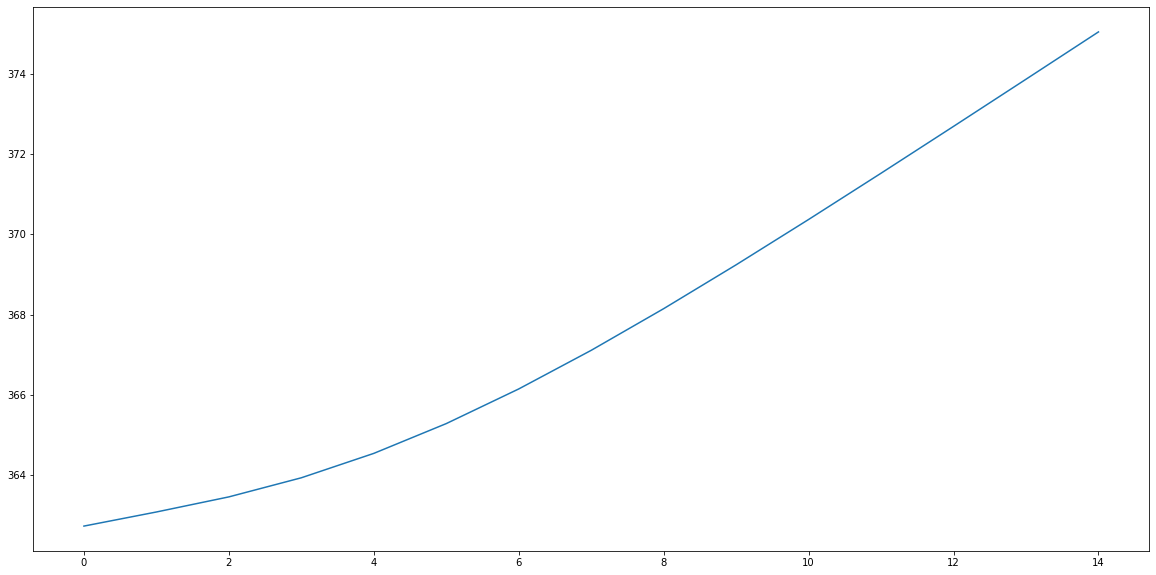

In [44]:
plt.plot(df3)

In [5]:
import pandas as pd
banks = {
    "AXIS_BANK": "not defined",
    "BAJAJ_FINANCE" : "not defined",
    "BAJAJ_FINSERV" : "not defined",
    "HDFC_BANK" : "not defined",
    "ICICI" : "not defined",
    "INDUSIND_BANK" : "not defined",
    "KOTAK_MAHINDRA" : "not defined",
    "SBI" : "not defined"  
}

for i in banks:
    path = "./Dataset/BanksDataset/"+i+".csv"
    data = pd.read_csv(path)
    x = predict(data)
    banks[i] = x